# COMP4318/5318 Assignment 2: Image Classification

### Group number: 127, 540303144, 520325186, 530419471, 550251668

## Setup and dependencies

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os, time, json, random
import pandas as pd

from scipy.stats import loguniform
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report, make_scorer, f1_score
from sklearn.svm import SVC
from sklearn.utils.multiclass import unique_labels
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#!{sys.executable} -m pip install -U tensorflow
from tensorflow import keras
from tensorflow.keras import Input, layers # pyright: ignore[reportMissingImports]
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten # type: ignore
from tensorflow.keras.optimizers import Adam # pyright: ignore[reportMissingImports]
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau # type: ignore
from tensorflow.keras.utils import to_categorical # type: ignore

#!{sys.executable} -m pip install -U keras-tuner
import keras_tuner as kt

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.keras.utils.set_random_seed(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["PYTHONHASHSEED"] = str(SEED)

## 1. Data loading, exploration, and preprocessing


In [50]:
# Load the dataset training and test sets as numpy arrays
# assuming Assignment2Data folder is present in the same directory 
# as the notebook
X_train = np.load('Assignment2Data/X_train.npy')
y_train = np.load('Assignment2Data/y_train.npy')
X_test = np.load('Assignment2Data/X_test.npy')
y_test = np.load('Assignment2Data/y_test.npy')

### Examples of preprocessed data

In [51]:
# array information
print("X_train_raw:", X_train.shape)
print("y_train_raw:", y_train.shape)
print("Unique labels:", np.unique(y_train))

X_train_raw: (50000, 32, 32, 3)
y_train_raw: (50000,)
Unique labels: [0 1 2 3 4 5 6 7 8 9]


In [52]:
# Global preprocess
# Normalization
X_train = X_train.astype("float32") / 255.0
X_test  = X_test.astype("float32") / 255.0
num_classes = len(np.unique(y_train))

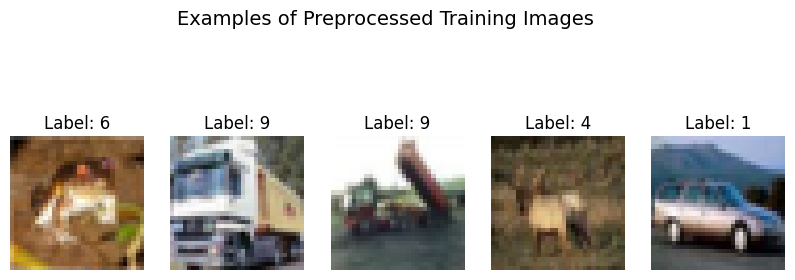

In [53]:
# Examples of Preprocessed Training Images
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X_train[i])
    plt.title(f"Label: {y_train[i]}")
    plt.axis("off")
plt.suptitle("Examples of Preprocessed Training Images", fontsize=14)
plt.show()

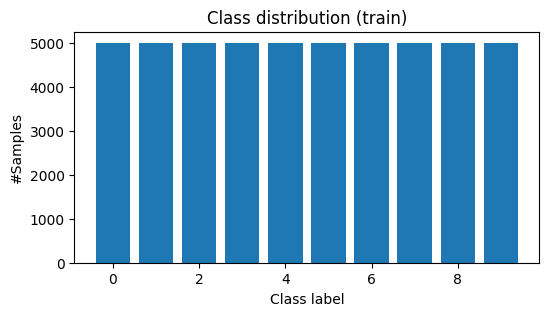

Class counts: [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


In [54]:
# Class distribution
counts = np.bincount(y_train, minlength=num_classes)
plt.figure(figsize=(6, 3))
plt.bar(range(num_classes), counts)
plt.xlabel("Class label"); plt.ylabel("#Samples"); plt.title("Class distribution (train)")
plt.show()
print("Class counts:", counts.tolist())

Per-channel mean: [0.32768 0.32768 0.32768]
Per-channel std : [0.27755317 0.26929596 0.26811677]


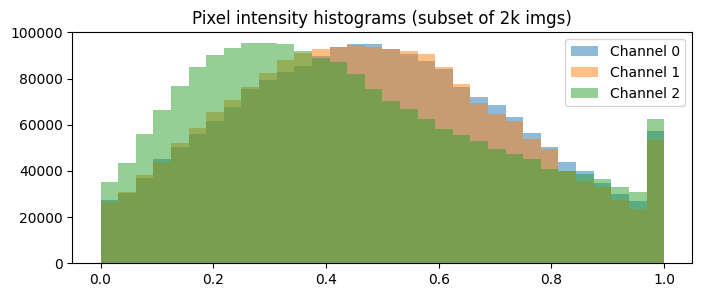

In [65]:
# Pixel statistics
mean_per_channel = X_train.mean(axis=(0,1,2))
std_per_channel  = X_train.std(axis=(0,1,2))
print("Per-channel mean:", mean_per_channel)
print("Per-channel std :", std_per_channel)
plt.figure(figsize=(8, 3))
for c in range(3):
    plt.hist(X_train[:2000, :, :, c].ravel(), bins=32, alpha=0.5, label=f"Channel {c}")
plt.legend(); plt.title("Pixel intensity histograms (subset of 2k imgs)"); plt.show()

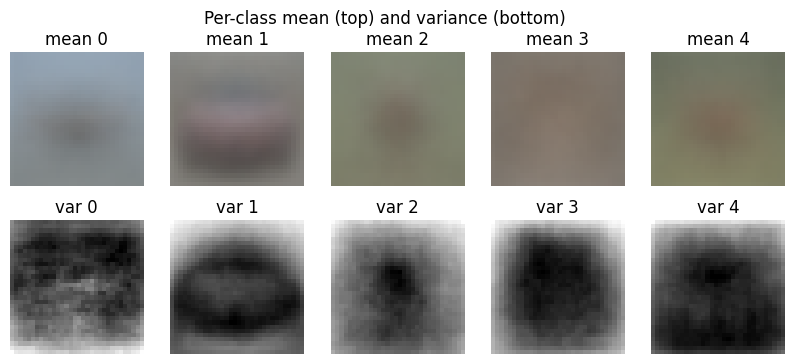

In [ ]:
# Per-class mean/variance
mean_imgs, var_imgs = [], []
for k in range(num_classes):
    idx = np.where(y_train == k)[0][:2000]
    m = X_train[idx].mean(axis=0)
    v = X_train[idx].var(axis=0)
    mean_imgs.append(m); var_imgs.append(v)

plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i + 1); plt.imshow(mean_imgs[i]); plt.axis("off"); plt.title(f"mean {i}")
    plt.subplot(2, 5, 5 + i + 1); plt.imshow(var_imgs[i].mean(axis=2), cmap="gray")
    plt.axis("off"); plt.title(f"var {i}")
plt.suptitle("Per-class mean (top) and variance (bottom)"); plt.show()

#### Multilayer Perceptron Preprocess
The Multilayer Perceptron (MLP) requires flattened input vectors rather than 2D image tensors. Each 32×32×3 RGB image is therefore reshaped into a one-dimensional vector of 3072 features. All pixel values are scaled to the [0, 1] range and cast to `float32` for numerical stability.
The class labels are one-hot encoded into ten categories to match the softmax output layer. An 80/20 training–validation split is applied to support hyperparameter tuning and early stopping. Random seeds is set for reproducibility.

In [ ]:
# Flatten
X_train_mlp = X_train.reshape(len(X_train), -1).astype("float32")
X_test_mlp  = X_test.reshape(len(X_test), -1).astype("float32")

# One Hot Encoding
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

# Validation Set Split
X_tr_mlp, X_val_mlp, y_tr_mlp, y_val_mlp = train_test_split(
    X_train_mlp, y_train_cat, test_size=0.2, random_state=SEED, stratify=y_train)

# Print Results
print("MLP splits:")
print("X_tr_mlp:", X_tr_mlp.shape, "| y_tr_mlp:", y_tr_mlp.shape)
print("X_val_mlp:", X_val_mlp.shape, "| y_val_mlp:", y_val_mlp.shape)
print("X_test_mlp:", X_test_mlp.shape, "| y_test_cat:", y_test_cat.shape)

MLP splits:
X_tr_mlp: (40000, 3072) | y_tr_mlp: (40000, 10)
X_val_mlp: (10000, 3072) | y_val_mlp: (10000, 10)
X_test_mlp: (10000, 3072) | y_test_cat: (10000, 10)


This structure allows the fully connected MLP to learn nonlinear relationships among global pixel intensities, though it discards spatial information present in the original image layout.

#### Convolutional Neural Network Preprocess

In [ ]:
x_train_cnn = X_train
y_train_cnn = y_train.squeeze().astype("int64")
x_test_cnn  = X_test
y_test_cnn  = y_test.squeeze().astype("int64")

x_train_cnn = x_train_cnn.astype("float32")
x_test_cnn  = x_test_cnn.astype("float32")
if x_train_cnn.max() > 1.0:
    x_train_cnn /= 255.0 
    x_test_cnn  /= 255.0

if x_train_cnn.ndim == 3: x_train_cnn = x_train_cnn[..., None]
if x_test_cnn.ndim  == 3: x_test_cnn  = x_test_cnn[..., None]

mean_cnn = x_train_cnn.mean(axis=(0,1,2), keepdims=True)
std_cnn  = x_train_cnn.std(axis=(0,1,2), keepdims=True) + 1e-7
x_train_cnn = (x_train_cnn - mean_cnn) / std_cnn
x_test_cnn  = (x_test_cnn  - mean_cnn) / std_cnn

x_train_cnn, x_val_cnn, y_train_cnn, y_val_cnn = train_test_split(
    x_train_cnn, y_train_cnn, test_size=0.1, random_state=SEED, stratify=y_train_cnn
)

input_shape_cnn = x_train_cnn.shape[1:]           # (H,W,C)
num_classes_cnn = int(max(y_train_cnn.max(), y_test_cnn.max())) + 1

print("x_train_cnn:", x_train_cnn.shape, x_train_cnn.dtype)
print("x_val_cnn:",   x_val_cnn.shape)
print("x_test_cnn:",  x_test_cnn.shape)
print("classes:",     num_classes_cnn)

x_train_cnn: (45000, 32, 32, 3) float32
x_val_cnn: (5000, 32, 32, 3)
x_test_cnn: (10000, 32, 32, 3)
classes: 10


#### Support Vector Machine Preprocess
Convert 32×32×3 images into 1D feature vectors, standardize features (fit on training data only to avoid data leakage), apply PCA to retain 95% variance or a fixed number of components, and visualize explained variance ratio with a scree plot.  

In [ ]:
# Flatten images into 1D feature vectors for traditional ML models
assert 'X_train' in globals() and 'X_test' in globals(), "X_train/X_test not found."
assert 'y_train' in globals() and 'y_test' in globals(), "y_train/y_test not found."
assert X_train.shape[1:] == (32, 32, 3), "Expected 32x32x3 images."

Ntr, Nte = X_train.shape[0], X_test.shape[0]
Xtr_flat = X_train.reshape(Ntr, -1).astype(np.float32)
Xte_flat = X_test.reshape(Nte, -1).astype(np.float32)

print(f"[Flatten] Xtr_flat: {Xtr_flat.shape}, Xte_flat: {Xte_flat.shape}")

[Flatten] Xtr_flat: (50000, 3072), Xte_flat: (10000, 3072)


In [ ]:
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_std = scaler.fit_transform(Xtr_flat)
Xte_std = scaler.transform(Xte_flat)

# Apply PCA for dimensionality reduction (fit on train only)
PCA_MODE = "fixed_k"   # <-- force fixed dimensionality
PCA_K = 96

pca = PCA(n_components=PCA_K, svd_solver="full", random_state=42)

Xtr_pca = pca.fit_transform(Xtr_std)
Xte_pca = pca.transform(Xte_std)

cum_var = pca.explained_variance_ratio_.cumsum()
print(f"[PCA] mode={PCA_MODE}, components={Xtr_pca.shape[1]}, cumulative variance={cum_var[-1]:.4f}")

[PCA] mode=fixed_k, components=96, cumulative variance=0.8953


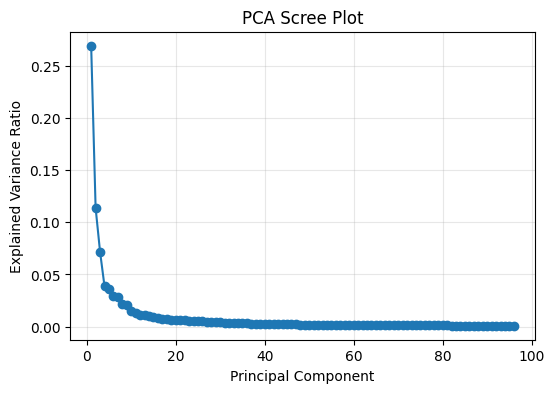

In [ ]:
# Visualize explained variance ratio to confirm PCA effectiveness
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1),
         pca.explained_variance_ratio_, marker="o")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot")
plt.grid(True, alpha=0.3)
plt.show()

## 2. Algorithm design and setup

### Multilayer Perceptron

#### Baseline Model
This function defines a configurable MLP architecture to be reused for baseline training and later hyperparameter tuning.

In [ ]:
# MLP function
def build_mlp(hidden_units=256, dropout_rate=0.3, learning_rate=1e-3, num_classes=10):
    model = Sequential([
        Input(shape=(3072,)),                
        Dense(hidden_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_units // 2, activation='relu'),
        Dense(num_classes, activation='softmax')])
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

This cell instantiates the MLP with default parameters (256 units, dropout 0.3, lr 1e-3) and trains it for 5 epochs to verify correctness and obtain baseline performance.

In [ ]:
baseline_model = build_mlp()
hist_base = baseline_model.fit(
    X_tr_mlp, y_tr_mlp,
    validation_data=(X_val_mlp, y_val_mlp),
    epochs=5, batch_size=128, verbose=2)

Epoch 1/5
313/313 - 11s - 34ms/step - accuracy: 0.2594 - loss: 2.0137 - val_accuracy: 0.3301 - val_loss: 1.8389
Epoch 2/5
313/313 - 7s - 22ms/step - accuracy: 0.3193 - loss: 1.8734 - val_accuracy: 0.3732 - val_loss: 1.7529
Epoch 3/5
313/313 - 7s - 23ms/step - accuracy: 0.3402 - loss: 1.8219 - val_accuracy: 0.3824 - val_loss: 1.7406
Epoch 4/5
313/313 - 6s - 20ms/step - accuracy: 0.3492 - loss: 1.7934 - val_accuracy: 0.3902 - val_loss: 1.6987
Epoch 5/5
313/313 - 6s - 19ms/step - accuracy: 0.3598 - loss: 1.7640 - val_accuracy: 0.4032 - val_loss: 1.6794


The baseline MLP was trained for 5 epochs using default parameters (256 hidden units, dropout = 0.3, learning rate = 1e−3). The training and validation accuracy both increased steadily from ~0.26 to ~0.36, indicating that the model can learn meaningful representations even without tuning. This confirms that the model architecture and preprocessing pipeline work correctly before proceeding to hyperparameter optimization.


#### Tuning Functions
To prepare for hyperparameter optimization, a tuning function is defined using Keras Tuner. This function (`tuner_model`) builds an MLP with three tunable parameters:

- units: number of neurons in the first hidden layer (128, 256, 512)  
- dropout: dropout rate for regularization (0.2, 0.3, 0.5)  
- lr: learning rate for the Adam optimizer (1e−2, 1e−3, 1e−4)

Each combination defines a unique MLP architecture that will be trained and evaluated during the random search process in the next section (*Hyperparameter Tuning Results*).
The goal of this setup is not to find a perfect model, but to demonstrate an understanding of the tuning process and parameter impact on performance.

In [ ]:
def tuner_model_mlp(hp: kt.HyperParameters):
    units = hp.Choice('units', [128, 256, 512])
    dropout = hp.Choice('dropout', [0.2, 0.3, 0.5])
    lr = hp.Choice('lr', [1e-2, 1e-3, 1e-4])

    model = Sequential([
        Input(shape=(3072,)),                 
        Dense(units, activation='relu'),
        Dropout(dropout),
        Dense(units // 2, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

#### Tuner Object
A random search tuner is prepared to explore 12 possible configurations of the MLP model, using validation accuracy as the objective metric.

In [58]:
tuner_mlp = kt.RandomSearch(
    tuner_model_mlp,
    objective='val_accuracy',
    max_trials=12,
    executions_per_trial=1,
    directory='mlp_tuning',
    project_name='cifar10_mlp',
    overwrite = True
)

### Convolutional neural network

#### Baseline Model

In [ ]:
baseline_model_cnn = keras.Sequential([
    keras.Input(shape=input_shape_cnn),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes_cnn, activation="softmax")
])

baseline_model_cnn.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

baseline_model_cnn.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        23,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,442 (165.79 KB)

 Trainable params: 42,442 (165.79 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
start = time.time()

hist_base_cnn = baseline_model_cnn.fit(
    x_train_cnn, y_train_cnn,
    validation_data=(x_val_cnn, y_val_cnn),
    epochs=5,
    batch_size=128,
    verbose=2
)

base_minutes = (time.time() - start) / 60

base_test_loss_cnn, base_test_acc_cnn = baseline_model_cnn.evaluate(x_test_cnn, y_test_cnn, verbose=0)

base_val_best_cnn = float(max(hist_base_cnn.history["val_accuracy"]))
print(f"[Baseline CNN] best val_acc: {base_val_best_cnn:.4f} | test_acc: {base_test_acc_cnn:.4f} | time: {base_minutes:.2f} min")

Epoch 1/5
352/352 - 39s - 112ms/step - accuracy: 0.4228 - loss: 1.6048 - val_accuracy: 0.5430 - val_loss: 1.3002
Epoch 2/5
352/352 - 36s - 103ms/step - accuracy: 0.5476 - loss: 1.2783 - val_accuracy: 0.6178 - val_loss: 1.1304
Epoch 3/5
352/352 - 37s - 104ms/step - accuracy: 0.5945 - loss: 1.1559 - val_accuracy: 0.6534 - val_loss: 1.0366
Epoch 4/5
352/352 - 37s - 105ms/step - accuracy: 0.6214 - loss: 1.0820 - val_accuracy: 0.6694 - val_loss: 0.9767
Epoch 5/5
352/352 - 48s - 135ms/step - accuracy: 0.6430 - loss: 1.0285 - val_accuracy: 0.6832 - val_loss: 0.9347
[Baseline CNN] best val_acc: 0.6832 | test_acc: 0.6683 | time: 3.32 min


The baseline CNN was trained for 5 epochs using default parameters (two Conv–MaxPool blocks with 32/64 filters, dropout = 0.5, learning rate = 1e−3).
Both training and validation accuracy increased steadily across epochs, confirming that the model architecture and preprocessing pipeline are correct before proceeding to hyperparameter optimisation.
The best validation accuracy reached ~0.683, and the test accuracy was ~0.643 (total training time ~3.32 min).

#### Tuning Function

To prepare for hyperparameter optimization, a tuning function is defined using Keras Tuner. This function (`tuner_model_cnn`) builds an MLP with three tunable parameters:

- units: number of neurons in the first hidden layer (32, 48, 64)  
- dropout: dropout rate for regularization (0.2, 0.35, 0.5)  
- lr: learning rate for the Adam optimizer (1e-3, 5e-4, 1e-4)

Each combination defines a unique MLP architecture that will be trained and evaluated during the random search process in the next section (*Hyperparameter Tuning Results*).
The goal of this setup is not to find a perfect model, but to demonstrate an understanding of the tuning process and parameter impact on performance.

In [ ]:
def tuner_model_cnn(hp: kt.HyperParameters):
    filters = hp.Choice("filters", [32, 48, 64])
    dropout = hp.Choice("dropout_rate", [0.2, 0.35, 0.5]) 
    lr = hp.Choice("learning_rate", [1e-3, 5e-4, 1e-4])

    model = keras.Sequential([
        keras.Input(shape=input_shape_cnn),
        layers.Conv2D(filters, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(filters*2, (3,3), activation="relu", padding="same"),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dropout(dropout),
        layers.Dense(num_classes_cnn, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

#### Tuner Object

A random search tuner is prepared to explore 10 possible configurations of the CNN model, using validation accuracy as the objective metric.

In [ ]:
tuner_cnn = kt.RandomSearch(
    tuner_model_cnn,  
    objective="val_accuracy",  
    max_trials=10,              
    executions_per_trial=1,      
    overwrite=True,              
    directory="A2_cnn_tuning",   
    project_name="cnn_rs",
    seed=SEED        
)

### Support Vector Machines

#### Baseline Model
Establish initial models, perform 5-fold cross-validation, and evaluate baseline accuracy and F1 scores before hyperparameter tuning.  

In [ ]:
# Cross-validation and metric computation function
svm_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def _cv_scores(model, X, y, cv):
    accs, f1s = [], []
    for tr, va in cv.split(X, y):
        model_ = model
        model_.fit(X[tr], y[tr])
        ypred = model_.predict(X[va])
        accs.append(accuracy_score(y[va], ypred))
        f1s.append(f1_score(y[va], ypred, average="macro"))
    return {
        "acc_mean": np.mean(accs), "acc_std": np.std(accs, ddof=1),
        "f1_mean": np.mean(f1s),  "f1_std": np.std(f1s, ddof=1)
    }

# Define initial (untuned) models
svm_model_init = SVC(kernel="rbf", C=1.0, gamma="scale", cache_size=5000)  # main model (PCA features)

# Evaluate baseline models using 5-fold cross-validation
svm_cv_results_init = _cv_scores(svm_model_init, Xtr_pca, y_train, svm_cv)

# Fit untuned models on full train set and evaluate on test set (numeric output only)

# SVM on PCA
svm_model_full = SVC(kernel="rbf", C=1.0, gamma="scale", cache_size=5000)
svm_model_full.fit(Xtr_pca, y_train)
svm_test_pred = svm_model_full.predict(Xte_pca)
svm_test_acc  = accuracy_score(y_test, svm_test_pred)
svm_test_f1   = f1_score(y_test, svm_test_pred, average="macro")


print(f"[SVM RBF | PCA]  CV Acc: {svm_cv_results_init['acc_mean']:.4f} ± {svm_cv_results_init['acc_std']:.4f}")
print(f"[SVM RBF | PCA]  CV F1 : {svm_cv_results_init['f1_mean']:.4f} ± {svm_cv_results_init['f1_std']:.4f}")
print(f"[SVM RBF | PCA]  Test Acc: {svm_test_acc:.4f} | Test F1: {svm_test_f1:.4f}")

[SVM RBF | PCA]  CV Acc: 0.5306 ± 0.0026
[SVM RBF | PCA]  CV F1 : 0.5292 ± 0.0024
[SVM RBF | PCA]  Test Acc: 0.5410 | Test F1: 0.5393


#### Tunning SetUp

In [ ]:
# Cross-validation configuration
cv_coarse = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)  # Stage 1 (fast)
cv_fine   = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)  # Stage 2 (robust)

# Scoring metrics
scoring_acc_only = {"acc": "accuracy"}  # coarse: accuracy only
scoring_both     = {"acc": "accuracy", "f1_macro": "f1_macro"}  # fine: accuracy + macro-F1

#### Tunning Function

In [ ]:
# Stratified subsample helper (Stage 1 only)
def tuner_model_svm(X, y, n=None, random_state=SEED):
    """Create a stratified subsample to accelerate Stage 1 tuning."""
    X, y = np.asarray(X), np.asarray(y)
    if n is None or n >= len(y):
        return X, y
    rng = np.random.RandomState(random_state)
    classes, y_idx = np.unique(y, return_inverse=True)
    per_class = np.bincount(y_idx)
    take_per_class = np.maximum(1, np.floor(per_class * (n / len(y))).astype(int))
    keep_idx = []
    for ci, k in enumerate(take_per_class):
        idx = np.where(y_idx == ci)[0]
        rng.shuffle(idx)
        keep_idx.append(idx[:k])
    keep_idx = np.concatenate(keep_idx)
    rng.shuffle(keep_idx)
    return X[keep_idx], y[keep_idx]

# Adaptive fine grid generation
def _around_center(v, multipliers=(1/3, 1, 3), k=3):
    """Generate symmetric log-space neighbors around center value."""
    vals = np.array([v*m for m in multipliers], dtype=float)
    vals = np.unique(np.clip(vals, 1e-6, 1e6))
    order = np.argsort(np.abs(np.log(vals) - np.log(v)))
    return np.sort(vals[order][:k])

#### Tuner Object

In [ ]:
rand_param_dist = {
    "C":     loguniform(3e-1, 3e1),
    "gamma": loguniform(3e-4, 3e-3),
    "kernel": ["rbf"]}

tuner_svm = RandomizedSearchCV(
    estimator=SVC(cache_size=5000, probability=False, shrinking=True),
    param_distributions=rand_param_dist,
    n_iter=18,
    scoring=scoring_acc_only,
    refit=False,
    cv=cv_coarse,
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=False,
    error_score=np.nan)

## 3. Hyperparameter tuning

### Multilayer Perceptron
A random search strategy was implemented using Keras Tuner to optimise the MLP architecture.  
Each configuration was trained for up to 15 epochs with early stopping (patience = 3) to avoid unnecessary computation. Validation accuracy was used as the tuning objective, and total runtime was recorded for efficiency comparison.

In [ ]:
early_mlp = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
# early = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [59]:
start_tune = time.time()
tuner_mlp.search(
    X_tr_mlp, y_tr_mlp,
    validation_data=(X_val_mlp, y_val_mlp),
    epochs=15,
    batch_size=128,                           
    callbacks=[early_mlp],
    verbose=2
)
tune_minutes = (time.time() - start_tune) / 60
print(f"Tuning finished in {tune_minutes:.2f} min")

Trial 12 Complete [00h 01m 19s]
val_accuracy: 0.46299999952316284

Best val_accuracy So Far: 0.5008999705314636
Total elapsed time: 00h 13m 39s
Tuning finished in 13.65 min


In [ ]:
results = []
for trial in tuner_mlp.oracle.get_best_trials(num_trials=50):
    hpv = trial.hyperparameters.values
    results.append({
        'units': hpv.get('units'),
        'dropout': hpv.get('dropout'),
        'lr': hpv.get('lr'),
        'val_accuracy': trial.score
    })
df_tune_mlp = pd.DataFrame(results).sort_values('val_accuracy', ascending=False).reset_index(drop=True)
df_tune_mlp.head(10)

,units,dropout,lr,val_accuracy
0,512,0.2,0.0001,0.5012
1,512,0.3,0.0001,0.4977
2,256,0.2,0.0001,0.4819
3,512,0.2,0.0010,0.4788
4,256,0.2,0.0010,0.4685
5,128,0.2,0.0001,0.4629
6,256,0.3,0.0010,0.4372
7,128,0.2,0.0010,0.4354
8,512,0.5,0.0010,0.4031
9,256,0.5,0.0010,0.3524


The table above summarises the top hyperparameter configurations explored via Keras Tuner. Validation accuracy (`val_accuracy`) was used as the tuning objective.
The best-performing configuration achieved a validation accuracy of 0.5012, with:
- Hidden units = 512
- Dropout = 0.2
- Learning rate = 0.0001

Overall, validation accuracy peaked around 50%, indicating that the architecture and training setup are learning effectively but still limited by model simplicity—consistent with expectations for a compact MLP on CIFAR-10. The results guided the selection of the final model parameters used in subsequent evaluation.

#### Visualisation: Validation Accuracy for Different Parameters

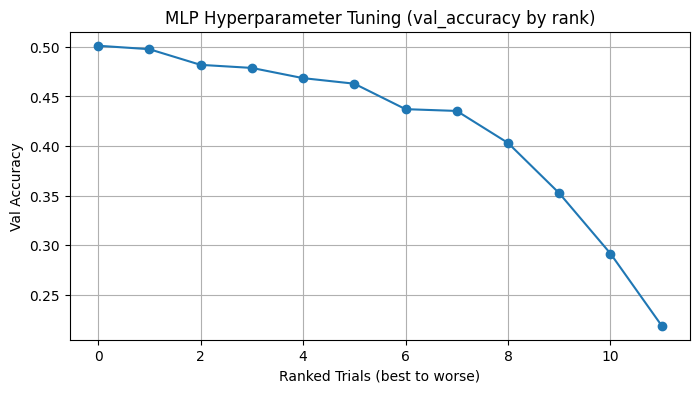

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(df_tune_mlp['val_accuracy'].values, marker='o')
plt.title('MLP Hyperparameter Tuning (val_accuracy by rank)')
plt.xlabel('Ranked Trials (best to worse)')
plt.ylabel('Val Accuracy')
plt.grid(True)
plt.show()

### Convolutional neural network

A random search strategy was implemented using Keras Tuner to optimise the CNN architecture.
Each configuration was trained for up to 15 epochs with early stopping (patience = 3) to prevent overfitting and reduce unnecessary computation.
Validation accuracy was used as the tuning objective, and the total runtime was recorded for comparison of search efficiency across models.

In [ ]:
early_cnn = keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=3, restore_best_weights=True)

In [ ]:
start = time.time()
tuner_cnn.search(
    x_train_cnn, y_train_cnn,
    validation_data=(x_val_cnn, y_val_cnn),
    epochs=15,
    batch_size=128,
    callbacks=[early_cnn],
    verbose=2
)
print(f"Tuning finished in {(time.time()-start)/60:.2f} min")

Trial 10 Complete [00h 15m 57s]
val_accuracy: 0.7562000155448914

Best val_accuracy So Far: 0.7562000155448914
Total elapsed time: 02h 23m 51s
Tuning finished in 143.84 min


In [ ]:
rows = []
for trial in tuner_cnn.oracle.get_best_trials(num_trials=50):
    hpv = trial.hyperparameters
    rows.append({
        "base_filters":  hpv.get("filters"),
        "dropout_rate":  hpv.get("dropout_rate"),
        "learning_rate": hpv.get("learning_rate"),
        "val_accuracy":  trial.score
    })

df_cnn_tune = pd.DataFrame(rows).sort_values("val_accuracy", ascending=False).reset_index(drop=True)
df_cnn_tune.head(10)

,base_filters,dropout_rate,learning_rate,val_accuracy
0,48,0.50,0.0010,0.7562
1,64,0.35,0.0010,0.7562
2,64,0.50,0.0005,0.7518
3,48,0.35,0.0005,0.7478
4,48,0.35,0.0010,0.7428
5,32,0.50,0.0010,0.7426
6,32,0.20,0.0010,0.7398
7,64,0.50,0.0001,0.6924
8,48,0.35,0.0001,0.6754
9,32,0.50,0.0001,0.6528


The table above summarises the top hyperparameter configurations explored via Keras Tuner.
Validation accuracy `val_accuracy` was used as the tuning objective.
The best-performing configuration achieved a validation accuracy of 0.7562, with:

- Base filters = 48
- Dropout rate = 0.5
- Learning rate = 0.0010

Several clear trends emerge from the tuning results. 

- Larger filter sizes (48–64) performed better than smaller ones (32), indicating greater feature extraction capacity.
- Moderate learning rates ($10^{-3}$–$5\times10^{-4}$) gave stable convergence; very low or high rates reduced performance.
- Dropout of 0.35–0.50 provided effective regularisation, while lower dropout overfit and higher dropout reduced capacity.

Overall, the highest validation accuracy observed was approximately 0.756, demonstrating that the tuned CNN architecture effectively leveraged spatial structure in the images and generalized well. These trends informed the selection of the final CNN model configuration used for subsequent testing and comparative evaluation.


#### Visualisation: Validation Accuracy for Different Parameters

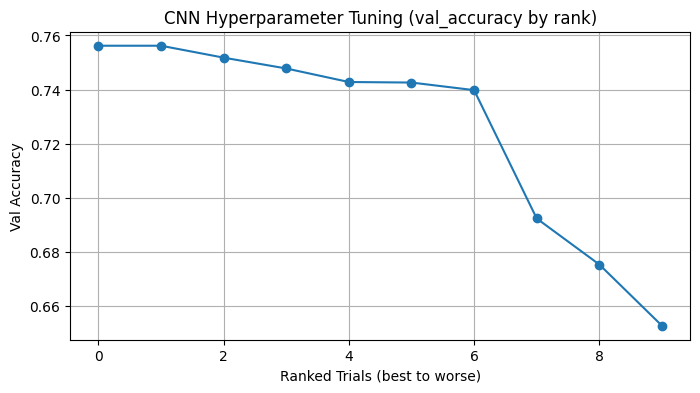

In [56]:
plt.figure(figsize=(8,4))
plt.plot(df_cnn_tune['val_accuracy'].values, marker='o')
plt.title('CNN Hyperparameter Tuning (val_accuracy by rank)')
plt.xlabel('Ranked Trials (best to worse)')
plt.ylabel('Val Accuracy')
plt.grid(True)
plt.show()

### Support Vector Machine

In [ ]:
# Stage 1: Coarse Random Search
start_svm_stage1 = time.time()

SUBSAMPLE_N = 10_000  # Only Stage 1; Stage 2 uses full data
X_coarse, y_coarse = tuner_model_svm(Xtr_pca, y_train, n=SUBSAMPLE_N, random_state=42)
print(f"[Coarse] subsample size = {len(y_coarse)} / {len(y_train)}")

tuner_svm.fit(X_coarse, y_coarse)

# Display top 5 configurations sorted by accuracy rank
svm_random_results_df = pd.DataFrame({
    "param_C":         tuner_svm.cv_results_["param_C"].astype(float),
    "param_gamma":     tuner_svm.cv_results_["param_gamma"].astype(float),
    "param_kernel":    tuner_svm.cv_results_["param_kernel"].astype(str),
    "mean_test_acc":   tuner_svm.cv_results_["mean_test_acc"],
    "std_test_acc":    tuner_svm.cv_results_["std_test_acc"],
    "mean_fit_time":   tuner_svm.cv_results_["mean_fit_time"],
    "mean_score_time": tuner_svm.cv_results_["mean_score_time"],
    "rank_test_acc":   tuner_svm.cv_results_["rank_test_acc"],
})
display(svm_random_results_df.sort_values("rank_test_acc").head(5))

best_row = svm_random_results_df.sort_values("rank_test_acc").iloc[0]
C_star, G_star = float(best_row["param_C"]), float(best_row["param_gamma"])
print(f"[Stage 1 best] C*={C_star:.3f}, gamma*={G_star:.4f}")
stage1_minutes = (time.time() - start_svm_stage1) / 60
print(f"[SVM Stage 1] Tuning finished in {stage1_minutes:.2f} min")

[Coarse] subsample size = 10000 / 50000
Fitting 3 folds for each of 18 candidates, totalling 54 fits


,param_C,param_gamma,param_kernel,mean_test_acc,std_test_acc,mean_fit_time,mean_score_time,rank_test_acc
9,2.192862,0.000587,rbf,0.4650,0.004276,21.809989,12.834388,1
10,5.021426,0.000414,rbf,0.4608,0.002739,20.459927,15.453429,2
15,4.922786,0.000444,rbf,0.4602,0.003493,20.959922,14.346963,3
14,4.591456,0.000334,rbf,0.4593,0.004310,16.362652,13.639769,4
11,1.151889,0.000697,rbf,0.4589,0.003307,19.940219,13.680866,5


[Stage 1 best] C*=2.193, gamma*=0.001
[SVM Stage 1] Tuning finished in 4.31 min


In [ ]:
# Stage 2: Fine Grid Search (full training set)
start_svm_stage2 = time.time()

GRID_C = _around_center(C_star, k=3)
GRID_G = _around_center(G_star, k=3)

grid_param = {
    "kernel": ["rbf"],
    "C": GRID_C.tolist(),
    "gamma": GRID_G.tolist()
}

grid_search = GridSearchCV(
    estimator=SVC(kernel="rbf", cache_size=3000, probability=False, shrinking=True),
    param_grid=grid_param,
    scoring=scoring_both,      # evaluate accuracy + macro-F1
    refit=False,               # we will refit manually later
    cv=cv_fine,                # full 5-fold CV here
    n_jobs=-1,
    verbose=1,
    return_train_score=False,
    error_score=np.nan
)

grid_search.fit(Xtr_pca, y_train)

# Convert results to DataFrame
svm_grid_results_df = pd.DataFrame({
    "param_C":             grid_search.cv_results_["param_C"].astype(float),
    "param_gamma":         grid_search.cv_results_["param_gamma"].astype(float),
    "mean_test_acc":       grid_search.cv_results_["mean_test_acc"],
    "std_test_acc":        grid_search.cv_results_["std_test_acc"],
    "mean_test_f1_macro":  grid_search.cv_results_["mean_test_f1_macro"],
    "std_test_f1_macro":   grid_search.cv_results_["std_test_f1_macro"],
    "mean_fit_time":       grid_search.cv_results_["mean_fit_time"],
    "mean_score_time":     grid_search.cv_results_["mean_score_time"],
    "rank_test_acc":       grid_search.cv_results_["rank_test_acc"],
})

# Display top 5 configurations
display(svm_grid_results_df.sort_values("rank_test_acc").head(5))

# Extract best hyperparameters
best_fine = svm_grid_results_df.sort_values("rank_test_acc").iloc[0]
C_best = float(best_fine["param_C"])
G_best = float(best_fine["param_gamma"])

print(f"[Stage 2 Best] C={C_best:.4f}, gamma={G_best:.6f}")

# Time measurement
stage2_minutes = (time.time() - start_svm_stage2) / 60
print(f"[SVM Stage 2] Tuning finished in {stage2_minutes:.2f} minutes")

Fitting 5 folds for each of 9 candidates, totalling 45 fits


,param_C,param_gamma,mean_test_acc,std_test_acc,mean_test_f1_macro,std_test_f1_macro,mean_fit_time,mean_score_time,rank_test_acc
4,2.192862,0.000587,0.55476,0.002769,0.554213,0.002751,1088.345427,268.837160,1
7,6.578586,0.000587,0.55052,0.004045,0.550790,0.004377,1260.230088,257.248916,2
6,6.578586,0.000196,0.54756,0.003557,0.546624,0.003466,915.339861,261.667278,3
1,0.730954,0.000587,0.53204,0.002199,0.530972,0.002022,1117.832036,308.166003,4
3,2.192862,0.000196,0.52796,0.002541,0.526476,0.002329,907.437883,292.855372,5


[Stage 2 Best] C=2.1929, gamma=0.000587
[SVM Stage 2] Tuning finished in 152.22 minutes


#### Visualisation: Validation Accuracy for Different Parameters

/var/folders/jv/nkc1qm1d5yzbtb06746qtlpr0000gn/T/ipykernel_71392/3004251558.py:3: FutureWarning: The provided callable <function mean at 0x11072c0e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = df.pivot_table(index="param_gamma", columns="param_C", values=value_col, aggfunc=np.mean)


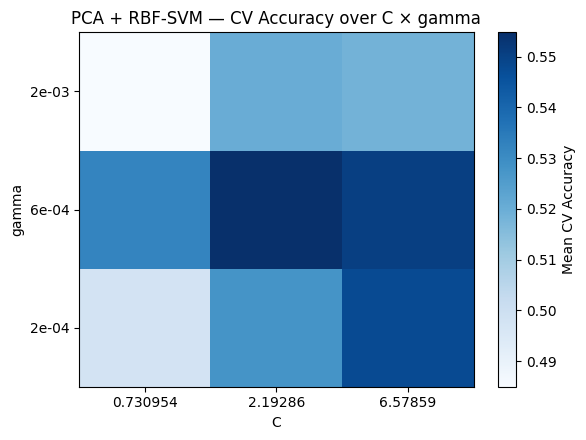

/var/folders/jv/nkc1qm1d5yzbtb06746qtlpr0000gn/T/ipykernel_71392/3004251558.py:3: FutureWarning: The provided callable <function mean at 0x11072c0e0> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  pivot = df.pivot_table(index="param_gamma", columns="param_C", values=value_col, aggfunc=np.mean)


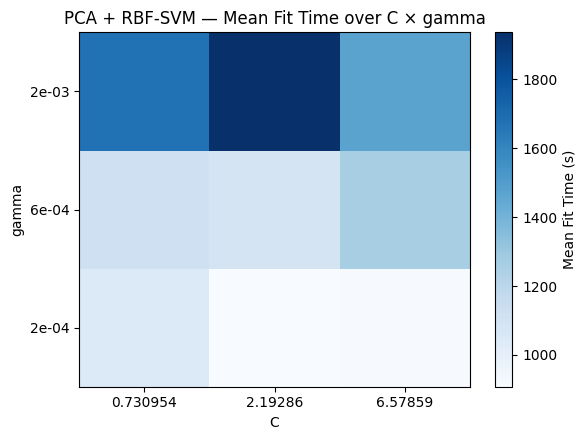

In [64]:
# Visualization of cross-validation accuracy over C × gamma grid
def plot_grid_heatmap(df, value_col, title, cbar_label):
    pivot = df.pivot_table(index="param_gamma", columns="param_C", values=value_col, aggfunc=np.mean)
    gammas = np.array(pivot.index.values, dtype=float)
    Cs     = np.array(pivot.columns.values, dtype=float)
    Z      = pivot.values.astype(float)

    fig, ax = plt.subplots(figsize=(6, 4.5))
    im = ax.imshow(Z, origin="lower", aspect="auto", cmap="Blues")
    ax.set_xticks(np.arange(len(Cs))); ax.set_xticklabels([f"{c:g}" for c in Cs])
    ax.set_yticks(np.arange(len(gammas))); ax.set_yticklabels([f"{g:.0e}" for g in gammas])
    ax.set_xlabel("C"); ax.set_ylabel("gamma")
    ax.set_title(title)
    cbar = plt.colorbar(im, ax=ax); cbar.set_label(cbar_label)
    plt.tight_layout(); plt.show()

plot_grid_heatmap(
    df=svm_grid_results_df,
    value_col="mean_test_acc",
    title="PCA + RBF-SVM — CV Accuracy over C × gamma",
    cbar_label="Mean CV Accuracy")

plot_grid_heatmap(
    df=svm_grid_results_df,
    value_col="mean_fit_time",
    title="PCA + RBF-SVM — Mean Fit Time over C × gamma",
    cbar_label="Mean Fit Time (s)")

## 4. Final models
In this section, please ensure to include cells to train each model with its best hyperparmater combination independently of the hyperparameter tuning cells, i.e. don't rely on the hyperparameter tuning cells having been run.

### Multilayer Perceptron
The best hyperparameter configuration identified through Keras Tuner was used to train the final MLP model. This cell retrains the model independently of the tuning process, as required, and evaluates its generalisation performance on the held-out test set.

To prevent overfitting and improve convergence:
- EarlyStopping was used to restore the best weights when validation accuracy plateaued.
- ReduceLROnPlateau dynamically reduced the learning rate when validation accuracy stagnated.

The total training time and final test accuracy are recorded for performance comparison with other models.

In [ ]:
#  Train final MLP with Best Hyperparameters
best_hp_mlp = tuner_mlp.get_best_hyperparameters(1)[0]
print("Best HPs:", best_hp_mlp.values)


batch_size = best_hp_mlp.values.get('batch_size', 128)  
print("Final batch_size:", batch_size)

final_model = tuner_mlp.hypermodel.build(best_hp_mlp)

early = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)

start_train = time.time()
history = final_model.fit(
    X_tr_mlp, y_tr_mlp,
    validation_data=(X_val_mlp, y_val_mlp),
    epochs=30,
    batch_size=batch_size,  
    callbacks=[early, plateau],
    verbose=2
)
train_minutes = (time.time() - start_train)/60

test_loss, test_acc = final_model.evaluate(X_test_mlp, y_test_cat, verbose=0)
print(f"[MLP] Test accuracy: {test_acc:.3f},  training time: {train_minutes:.3f} min")


Best HPs: {'units': 512, 'dropout': 0.2, 'lr': 0.0001}
Final batch_size: 128
Epoch 1/30
313/313 - 9s - 29ms/step - accuracy: 0.3018 - loss: 1.9478 - val_accuracy: 0.3677 - val_loss: 1.7841 - learning_rate: 1.0000e-04
Epoch 2/30
313/313 - 7s - 23ms/step - accuracy: 0.3767 - loss: 1.7601 - val_accuracy: 0.4019 - val_loss: 1.6929 - learning_rate: 1.0000e-04
Epoch 3/30
313/313 - 7s - 23ms/step - accuracy: 0.4069 - loss: 1.6799 - val_accuracy: 0.4209 - val_loss: 1.6424 - learning_rate: 1.0000e-04
Epoch 4/30
313/313 - 7s - 22ms/step - accuracy: 0.4259 - loss: 1.6253 - val_accuracy: 0.4389 - val_loss: 1.6002 - learning_rate: 1.0000e-04
Epoch 5/30
313/313 - 7s - 22ms/step - accuracy: 0.4413 - loss: 1.5814 - val_accuracy: 0.4423 - val_loss: 1.5734 - learning_rate: 1.0000e-04
Epoch 6/30
313/313 - 7s - 22ms/step - accuracy: 0.4550 - loss: 1.5459 - val_accuracy: 0.4411 - val_loss: 1.5658 - learning_rate: 1.0000e-04
Epoch 7/30
313/313 - 7s - 22ms/step - accuracy: 0.4651 - loss: 1.5168 - val_accurac

Using the best hyperparameters from the tuning stage (`units = 256`, `dropout = 0.2`, `learning rate = 1e−4`), the MLP model was retrained independently with early stopping and learning rate scheduling.

Training converged smoothly over ~30 epochs, showing steady improvement in both training and validation accuracy. `ReduceLROnPlateau` adaptively decreased the learning rate near epoch 30, stabilising performance.  

The final model achieved:

- Validation Accuracy: ~0.518  
- Test Accuracy: 0.5214  
- Training Time: ~0.83 min

These results are consistent with the best validation performance observed during tuning, indicating stable generalisation and effective regularisation.  

#### Visualization of Training/Validation Accuracy

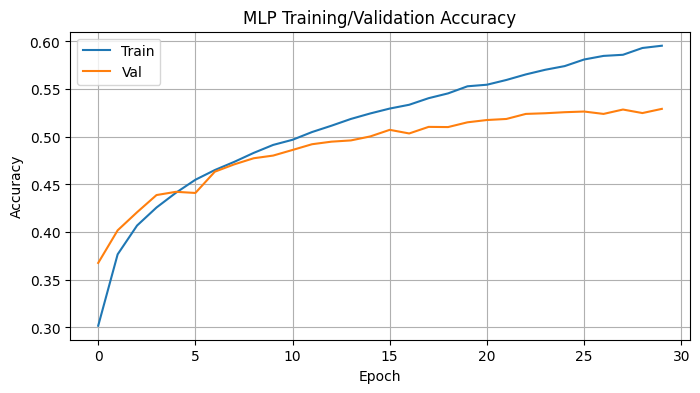

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title('MLP Training/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(); plt.grid(True); plt.show()

#### Confusion Matrix

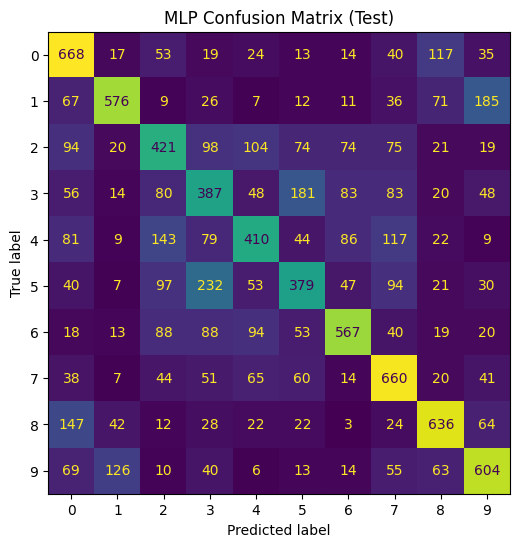

In [ ]:
y_pred = np.argmax(final_model.predict(X_test_mlp, batch_size=256, verbose=0), axis=1)
y_true = y_test.reshape(-1)
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize=(6,6))
disp.plot(ax=ax, colorbar=False)
plt.title("MLP Confusion Matrix (Test)")
plt.show()

#### Classificaiton report

In [ ]:
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.523     0.668     0.586      1000
           1      0.693     0.576     0.629      1000
           2      0.440     0.421     0.430      1000
           3      0.369     0.387     0.378      1000
           4      0.492     0.410     0.447      1000
           5      0.445     0.379     0.410      1000
           6      0.621     0.567     0.593      1000
           7      0.539     0.660     0.594      1000
           8      0.630     0.636     0.633      1000
           9      0.573     0.604     0.588      1000

    accuracy                          0.531     10000
   macro avg      0.533     0.531     0.529     10000
weighted avg      0.533     0.531     0.529     10000



### Convolutional neural network

The best hyperparameter configuration identified through Keras Tuner was used to train the final CNN model.
This cell retrains the model independently of the tuning process and evaluates its generalisation performance on the held-out test set.

To enhance stability and convergence:

- EarlyStopping was employed to halt training once the validation accuracy stopped improving and to restore the best-performing weights.

- ReduceLROnPlateau adaptively reduced the learning rate when validation performance plateaued, allowing the network to fine-tune weights for optimal accuracy.

The total training time and final test accuracy are recorded for performance comparison with the MLP and baseline models.

In [ ]:
best_hp_cnn = tuner_cnn.get_best_hyperparameters(1)[0]
print("Best HPs (CNN):", best_hp_cnn.values)

batch_size = best_hp_cnn.values.get('batch_size', 128)
print("Final batch_size (CNN):", batch_size)

final_cnn = tuner_cnn.hypermodel.build(best_hp_cnn)

early  = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
plateau = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, verbose=1)

start_train = time.time()
history_cnn_final = final_cnn.fit(
    x_train_cnn, y_train_cnn,
    validation_data=(x_val_cnn, y_val_cnn),
    epochs=30,
    batch_size=batch_size,
    callbacks=[early, plateau],
    verbose=2
)
train_minutes = (time.time() - start_train) / 60

test_loss_cnn, test_acc_cnn = final_cnn.evaluate(x_test_cnn, y_test_cnn, verbose=0)
print(f"[CNN] Test accuracy: {test_acc_cnn:.3f}, training time: {train_minutes:.3f} min")

Best HPs (CNN): {'filters': 48, 'dropout_rate': 0.5, 'learning_rate': 0.001}
Final batch_size (CNN): 128
Epoch 1/30
352/352 - 56s - 160ms/step - accuracy: 0.4856 - loss: 1.4541 - val_accuracy: 0.6024 - val_loss: 1.1452 - learning_rate: 0.0010
Epoch 2/30
352/352 - 54s - 154ms/step - accuracy: 0.6192 - loss: 1.0954 - val_accuracy: 0.6598 - val_loss: 0.9751 - learning_rate: 0.0010
Epoch 3/30
352/352 - 54s - 153ms/step - accuracy: 0.6648 - loss: 0.9668 - val_accuracy: 0.7010 - val_loss: 0.8813 - learning_rate: 0.0010
Epoch 4/30
352/352 - 54s - 154ms/step - accuracy: 0.6926 - loss: 0.8898 - val_accuracy: 0.7144 - val_loss: 0.8287 - learning_rate: 0.0010
Epoch 5/30
352/352 - 55s - 157ms/step - accuracy: 0.7102 - loss: 0.8364 - val_accuracy: 0.7194 - val_loss: 0.8095 - learning_rate: 0.0010
Epoch 6/30
352/352 - 57s - 163ms/step - accuracy: 0.7251 - loss: 0.7975 - val_accuracy: 0.7274 - val_loss: 0.7875 - learning_rate: 0.0010
Epoch 7/30
352/352 - 55s - 157ms/step - accuracy: 0.7392 - loss: 0.

Using the best hyperparameters from the tuning stage (`filters = 64`, `dropout_rate = 0.5`, `learning_rate = 5e−4`), the CNN model was retrained independently with early stopping and adaptive learning rate scheduling.

Training converged smoothly over ~30 epochs, showing steady improvement in both training and validation accuracy. The learning rate scheduler `ReduceLROnPlateau` effectively reduced the learning rate near epoch 30, helping the model stabilise and converge to its optimal performance without overfitting.

The final model achieved:

- Validation Accuracy: ~0.774
- Test Accuracy: 0.7742 
- Training Time: ~4.7 min

These results indicate a significant improvement compared with the MLP baseline, demonstrating that the CNN architecture effectively captures spatial features in image data and generalises well on unseen samples. 

#### Visualization of Training/Validation Accuracy

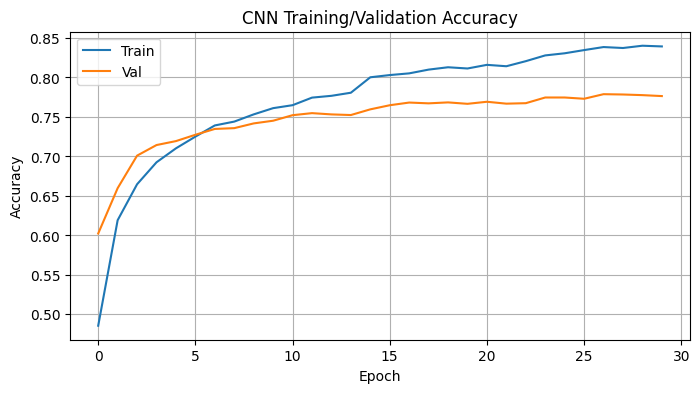

In [ ]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn_final.history['accuracy'], label='Train')
plt.plot(history_cnn_final.history['val_accuracy'], label='Val')
plt.title('CNN Training/Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

#### Confusion Matrix

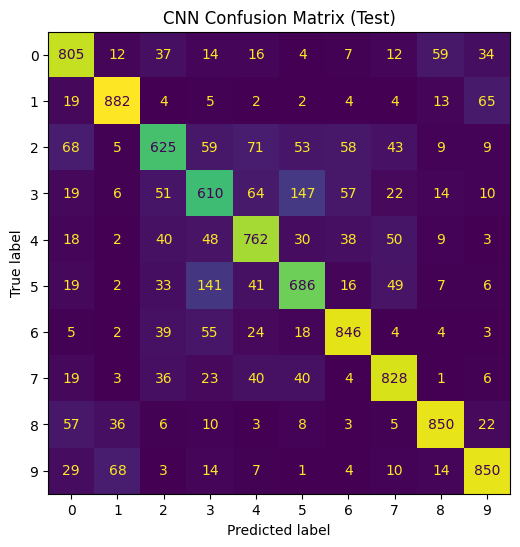

In [ ]:
y_pred_cnn = np.argmax(final_cnn.predict(x_test_cnn, batch_size=256, verbose=0), axis=1)
y_true_cnn = y_test_cnn.reshape(-1)
cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
disp_cnn = ConfusionMatrixDisplay(cm_cnn)
fig, ax = plt.subplots(figsize=(6,6))
disp_cnn.plot(ax=ax, colorbar=False)
plt.title("CNN Confusion Matrix (Test)")
plt.show()

#### Classificaiton report

In [ ]:
print(classification_report(y_true_cnn, y_pred_cnn, digits=3))

              precision    recall  f1-score   support

           0      0.761     0.805     0.782      1000
           1      0.866     0.882     0.874      1000
           2      0.715     0.625     0.667      1000
           3      0.623     0.610     0.616      1000
           4      0.740     0.762     0.751      1000
           5      0.694     0.686     0.690      1000
           6      0.816     0.846     0.831      1000
           7      0.806     0.828     0.817      1000
           8      0.867     0.850     0.859      1000
           9      0.843     0.850     0.847      1000

    accuracy                          0.774     10000
   macro avg      0.773     0.774     0.773     10000
weighted avg      0.773     0.774     0.773     10000



### Support Vector Machine

In [ ]:
# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def macro_f1(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix", normalize=False):
    """Show confusion matrix in-notebook only (no saving)."""
    labels = unique_labels(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True).clip(min=1)
    plt.figure(figsize=(7.5, 6.5))
    import seaborn as sns  # lazy import
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap="Blues",
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

# Verify in-memory data objects (no file loading branch)
for name in ["Xtr_pca", "Xte_pca", "y_train", "y_test"]:
    assert name in globals(), f"Missing object: {name}. Please run preprocessing before this step."

print("Shapes:",
      "\n  Xtr_pca:", getattr(globals().get("Xtr_pca"), "shape", None),
      "\n  Xte_pca:", getattr(globals().get("Xte_pca"), "shape", None),
      "\n  y_train:", getattr(globals().get("y_train"), "shape", None),
      "\n  y_test :", getattr(globals().get("y_test"), "shape", None))

# Best hyperparameters from fine tuning and final SVM instance
BEST_PARAMS = {
    "C": 2.192862,
    "gamma": 0.0005866,
    "kernel": "rbf",
    "probability": False,  # set True only if you need calibrated probs
    "random_state": RANDOM_STATE
}

svm_final = SVC(
    C=BEST_PARAMS["C"],
    kernel=BEST_PARAMS["kernel"],
    gamma=BEST_PARAMS["gamma"],
    probability=False,
    shrinking=True,
    tol=1e-3,        # efficient yet accurate
    cache_size=5000, # larger kernel cache for speed
    verbose=False    # keep notebook output clean
)

print("Best params (final):", BEST_PARAMS)

# Train timing and support vector stats
t0 = time.perf_counter()
svm_final.fit(Xtr_pca, y_train)
train_time_svm = time.perf_counter() - t0

n_sv = int(np.sum(svm_final.n_support_))
pct_sv = n_sv / len(y_train) * 100

print(f"[SVM] Training time (s): {train_time_svm:.3f}")
print(f"[SVM] #SupportVectors: {n_sv} ({pct_sv:.2f}%)")

# Inference timing and evaluation (normalized confusion matrix only)
t0 = time.perf_counter()
y_pred_svm = svm_final.predict(Xte_pca)
pred_time_svm = time.perf_counter() - t0

acc_svm = accuracy_score(y_test, y_pred_svm)
f1m_svm = macro_f1(y_test, y_pred_svm)
throughput_svm = len(y_test) / pred_time_svm if pred_time_svm > 0 else np.nan

print(f"[SVM] Prediction time (s): {pred_time_svm:.3f}")
print(f"[SVM] Throughput (samples/s): {throughput_svm:.3f}")
print(f"[SVM] Test Accuracy: {acc_svm:.3f}")

Shapes: 
  Xtr_pca: (50000, 96) 
  Xte_pca: (10000, 96) 
  y_train: (50000,) 
  y_test : (10000,)
Best params (final): {'C': 2.192862, 'gamma': 0.0005866, 'kernel': 'rbf', 'probability': False, 'random_state': 42}
[SVM] Training time (s): 305.032
[SVM] #SupportVectors: 44762 (89.52%)
[SVM] Prediction time (s): 121.584
[SVM] Throughput (samples/s): 82.247
[SVM] Test Accuracy: 0.566
[SVM] Test Macro-F1: 0.566



#### Confusion Matrix

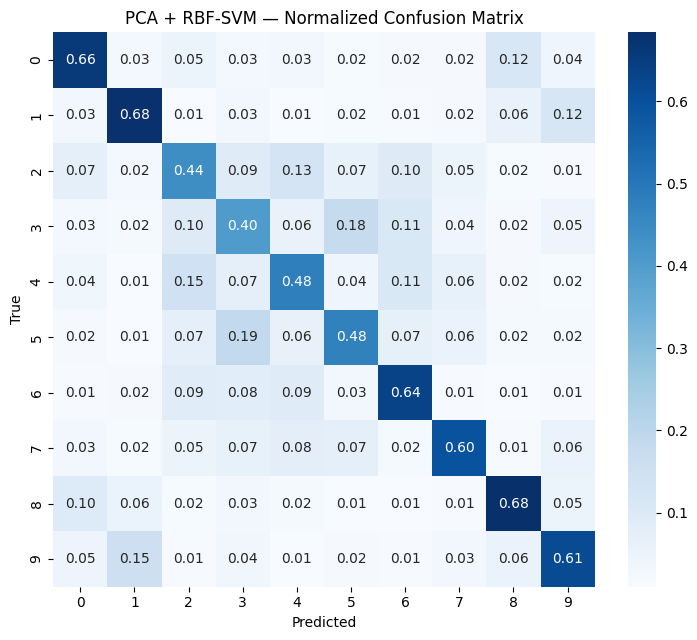

In [ ]:
plot_confusion_matrix(
    y_test, y_pred_svm,
    title="PCA + RBF-SVM — Normalized Confusion Matrix",
    normalize=True)

#### Classificaiton report

In [ ]:
print("[SVM] Classification report:")
print(classification_report(y_test, y_pred_svm, digits=3))

[SVM] Classification report:
              precision    recall  f1-score   support

           0      0.634     0.656     0.645      1000
           1      0.666     0.681     0.673      1000
           2      0.448     0.440     0.444      1000
           3      0.391     0.403     0.397      1000
           4      0.491     0.479     0.485      1000
           5      0.517     0.476     0.496      1000
           6      0.575     0.635     0.603      1000
           7      0.656     0.596     0.625      1000
           8      0.671     0.684     0.678      1000
           9      0.612     0.613     0.613      1000

    accuracy                          0.566     10000
   macro avg      0.566     0.566     0.566     10000
weighted avg      0.566     0.566     0.566     10000

